## Setup

Let's load all of the libraries we'll need.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

We also define some functions for interacting with the models.

In [2]:
def model_diagnostics(model, pr=True):
    """
    Returns and prints the R-squared, RMSE and the MAE
    for a trained model
    """
    y_predicted = model.predict(X_test)
    r2 = r2_score(y_test, y_predicted)
    mse = mean_squared_error(y_test, y_predicted)
    mae = mean_absolute_error(y_test, y_predicted)
    if pr:
        print(f"R-Sq: {r2:.4}")
        print(f"RMSE: {np.sqrt(mse)}")
        print(f"MAE: {mae}")
    
    return [r2,np.sqrt(mse),mae]


def plot_residuals(y_test, y_predicted):
    """"
    Plots the distribution for actual and
    predicted values of the target variable.
    Also plots the distribution for the residuals
    """
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True)
    sns.distplot(y_test, ax=ax0, kde = False)
    ax0.set(xlabel='Test scores')
    sns.distplot(y_predicted, ax=ax1, kde = False)
    ax1.set(xlabel="Predicted scores")
    plt.show()
    fig, ax2 = plt.subplots()
    sns.distplot((y_test-y_predicted), ax = ax2,kde = False)
    ax2.set(xlabel="Residuals")
    plt.show()
    
    
def y_test_vs_y_predicted(y_test,y_predicted):
    """
    Produces a scatter plot for the actual and
    predicted values of the target variable
    """
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_predicted)
    ax.set_xlabel("Test Scores")
    ax.set_ylim([-75, 1400])
    ax.set_ylabel("Predicted Scores")
    plt.show()
    
    
def get_feature_importance(model):
    """
    For fitted tree based models, get_feature_importance
    can be used to get the feature importance as a tidy output
    """
    X_non_text = pd.get_dummies(df[cat_cols])
    features = numeric_cols + bool_cols + list(X_non_text.columns)
    feature_importance = dict(zip(features, model.feature_importances_))
    for name, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
        print(f"{name:<30}: {importance:>6.2%}")
    print(f"\nTotal importance: {sum(feature_importance.values()):.2%}")
    return feature_importance

### Read in data

In [3]:
%%time
df = pd.read_pickle('reddit_comments.pkl')

CPU times: user 4.49 s, sys: 1.16 s, total: 5.65 s
Wall time: 5.69 s


**Handle missing values**
The data has some missing values, which are handled either by imputation or by dropping observations. Missing values occurred in the following columns for the following reasons:
- parent_score: some comments did not have a parent (imputed)
- comment_tree_root_score and time_since_comment_tree_root: some comments were the root of a comment tree (imputed)
- parent_cosine, parent_euc, title_cosine, title_euc: some comments lacked words that had glove word embeddings (dropped). In addition, some comments did not have a parent (parent_cosine, parent_title imputed)

In [4]:
%%time
df = df[~df.title_cosine.isna()] # drop where parent/title_cosine is NaN
parent_scrore_impute = df.parent_score.mode()[0] # impute with mode of parent_score column
comment_tree_root_score_impute = df.comment_tree_root_score.mode()[0] # impute with mode of comment_tree_root_score column
time_since_comment_tree_root_impute = df.time_since_comment_tree_root.mode()[0] # impute with mode of time_since_comment_tree_root column
parent_cosine_impute = 0
parent_euc_impute = 0
df.loc[df.parent_score.isna(), 'parent_score'] = parent_scrore_impute
df.loc[df.comment_tree_root_score.isna(), 'comment_tree_root_score'] = comment_tree_root_score_impute
df.loc[df.time_since_comment_tree_root.isna(), 'time_since_comment_tree_root'] = time_since_comment_tree_root_impute
df.loc[df.parent_cosine.isna(), 'parent_cosine'] = parent_cosine_impute
df.loc[df.parent_euc.isna(), 'parent_euc'] = parent_euc_impute

CPU times: user 925 ms, sys: 226 ms, total: 1.15 s
Wall time: 1.16 s


**Select variables**

In the next step, we define which variables to use when training the model. We make a list for boolean variables, for variables with multiple categories and for numeric variables.

In [5]:
bool_cols = ['over_18', 'is_edited', 'is_quoted', 'is_selftext']
cat_cols = ['subreddit', 'distinguished', 'is_flair', 'is_flair_css','hour_of_comment', 'weekday']

numeric_cols = ['gilded', 'controversiality', 'upvote_ratio','time_since_link',
                'depth', 'no_of_linked_sr', 'no_of_linked_urls', 'parent_score',
                'comment_tree_root_score', 'time_since_comment_tree_root',
                'subjectivity', 'senti_neg', 'senti_pos', 'senti_neu',
                'senti_comp', 'no_quoted', 'time_since_parent', 'word_counts',
                'no_of_past_comments', 'parent_cosine','parent_euc',
                'title_cosine', 'title_euc', 'no_quoted','link_score']

Using our list of variables, we can prepare the data for modeling. The step below uses scikit-learn's `LabelBinarizer` to make dummy variables out of the categorical columns then combines all variables.

In [6]:
lb = LabelBinarizer()
cat = [lb.fit_transform(df[col]) for col in cat_cols]
bol = [df[col].astype('int') for col in bool_cols]
t = df.loc[:, numeric_cols].values
final = [t] + bol + cat
y = df.score.values
x = np.column_stack(tuple(final))

We split the data into a training and test set using an 80–20 split.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

## Modeling

In this section, we use scikit-learn to fit models on the Reddit data. We start with a baseline model, then try to improve results with Lasso, Ridge, and Elastic Net Regression. In addition, we try K-Nearest Neighbors, Decision Tree, Random Forest and Gradient Boosted Regression.

First, let's define a dictionary that will store the results of the model diagnostics.

In [8]:
model_performance_dict = dict()

### Linear Regression Models

**Baseline Model**

We fit a simple model to establish a baseline. This model always predicts the mean number of upvotes.

In [9]:
%%time
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train,y_train)
model_performance_dict["Baseline"] = model_diagnostics(baseline)

R-Sq: -5.417e-08
RMSE: 68.73602955302476
MAE: 13.177054365169608
CPU times: user 4.05 s, sys: 362 ms, total: 4.41 s
Wall time: 4.4 s


**Linear Regression**

In [10]:
%%time
linear = LinearRegression()
linear.fit(X_train,y_train)
model_performance_dict["Linear Regression"] = model_diagnostics(linear)

R-Sq: 0.06738
RMSE: 66.3798087746185
MAE: 13.803146726230315
CPU times: user 11.5 s, sys: 1.24 s, total: 12.8 s
Wall time: 8.38 s


**Lasso Regression**

In [11]:
%%time
lasso = LassoCV(cv=30).fit(X_train, y_train)
model_performance_dict["Lasso Regression"] = model_diagnostics(lasso)

R-Sq: 0.0182
RMSE: 68.10773517021772
MAE: 13.51401710425848
CPU times: user 1min 12s, sys: 18.4 s, total: 1min 30s
Wall time: 1min 27s


**Ridge Regression**

In [12]:
%%time
ridge = RidgeCV(cv=10).fit(X_train, y_train)
model_performance_dict["Ridge Regression"] = model_diagnostics(ridge)

R-Sq: 0.0674
RMSE: 66.37936915515536
MAE: 13.802929075401869
CPU times: user 5min 3s, sys: 36 s, total: 5min 39s
Wall time: 5min 35s


**Elastic Net Regression**

In [13]:
%%time
elastic_net = ElasticNetCV(cv = 30).fit(X_train, y_train)
model_performance_dict["Elastic Net Regression"] = model_diagnostics(elastic_net)

R-Sq: 0.01819
RMSE: 68.10790740344011
MAE: 13.513380839643252
CPU times: user 1min 10s, sys: 17.7 s, total: 1min 28s
Wall time: 1min 24s


### Nonlinear Regression Models

**K-Nearest Neighbor Regression**

In [14]:
%%time
knr = KNeighborsRegressor()
knr.fit(X_train, y_train)
model_performance_dict["KNN Regression"] = model_diagnostics(knr)

R-Sq: 0.00727
RMSE: 68.48570585646834
MAE: 11.87172376020713
CPU times: user 1min 22s, sys: 686 ms, total: 1min 23s
Wall time: 1min 23s


**Decision Tree Regression**

In [15]:
%%time
dt = DecisionTreeRegressor(min_samples_split=45, min_samples_leaf=45, random_state = 10)
dt.fit(X_train, y_train)
model_performance_dict["Decision Tree"] = model_diagnostics(dt)

R-Sq: 0.2319
RMSE: 60.24043875345458
MAE: 10.174068516033042
CPU times: user 52.6 s, sys: 364 ms, total: 53 s
Wall time: 53.1 s


**Random Forest Regression**

In [16]:
%%time
rf = RandomForestRegressor(n_jobs=-1, n_estimators=70, min_samples_leaf=10, random_state = 10)
rf.fit(X_train, y_train)
model_performance_dict["Random Forest"] = model_diagnostics(rf)

R-Sq: 0.2832
RMSE: 58.19380993846686
MAE: 9.726769993712713
CPU times: user 1h 20min 1s, sys: 26.1 s, total: 1h 20min 27s
Wall time: 11min 48s


**Gradient Boosting Regression**

In [17]:
%%time
gbr = GradientBoostingRegressor(n_estimators=70, max_depth=5)
gbr.fit(X_train, y_train)
model_performance_dict["Gradient Boosting Regression"] = model_diagnostics(gbr)

R-Sq: 0.2599
RMSE: 59.131316412518196
MAE: 10.405170769017177
CPU times: user 19min 4s, sys: 9.19 s, total: 19min 13s
Wall time: 19min 24s


## Model comparison

We compare the models based on three metrics: RMSE, MAE, and R<sup>2</sup>. To do so, we define the function below.

In [18]:
def model_comparison(model_performance_dict, sort_by = 'RMSE', metric = 'RMSE'):

    Rsq_list = []
    RMSE_list = []
    MAE_list = []
    for key in model_performance_dict.keys():
        Rsq_list.append(model_performance_dict[key][0])
        RMSE_list.append(model_performance_dict[key][1])
        MAE_list.append(model_performance_dict[key][2])

    props = pd.DataFrame([])

    props["R-squared"] = Rsq_list
    props["RMSE"] = RMSE_list
    props["MAE"] = MAE_list
    props.index = model_performance_dict.keys()
    props = props.sort_values(by = sort_by, ascending=False)

    fig, ax = plt.subplots(figsize = (12,6))

    ax.bar(props.index.sort_values(), props[metric], color="blue")
    xt = props.index
    ax.set_xticklabels(xt)
    plt.title(metric)
    plt.xlabel('Model') 
    plt.xticks(rotation = 45)
    plt.ylabel(metric) 

Let's use this function to compare the models based on each metric.

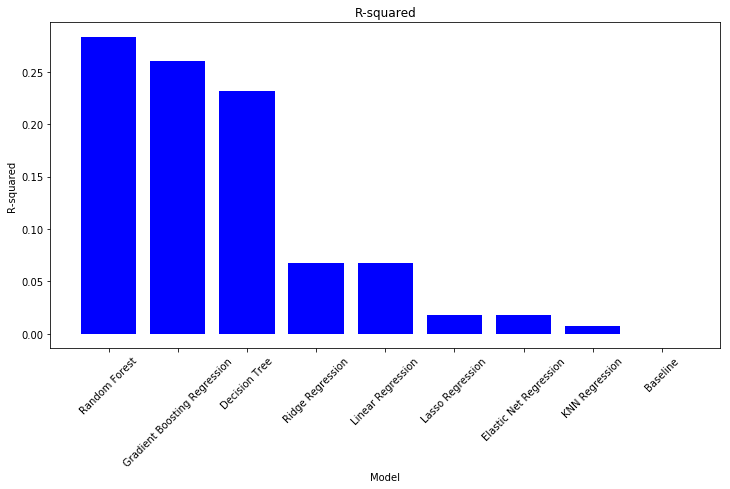

In [19]:
model_comparison(model_performance_dict, sort_by = 'R-squared', metric = 'R-squared')

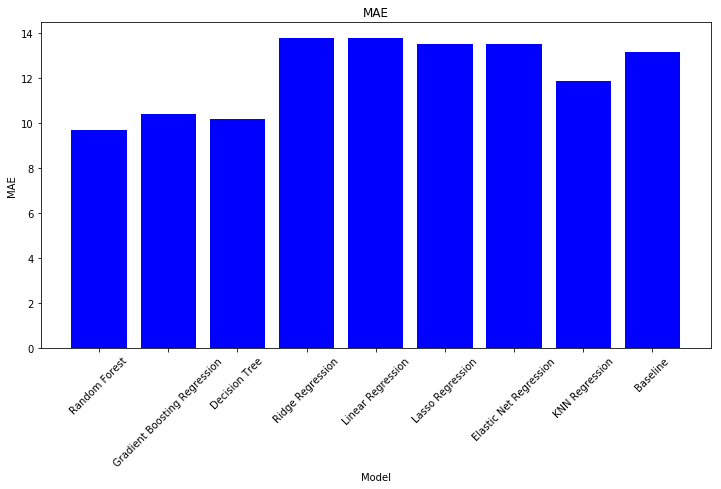

In [20]:
model_comparison(model_performance_dict, sort_by = 'R-squared', metric = 'MAE')

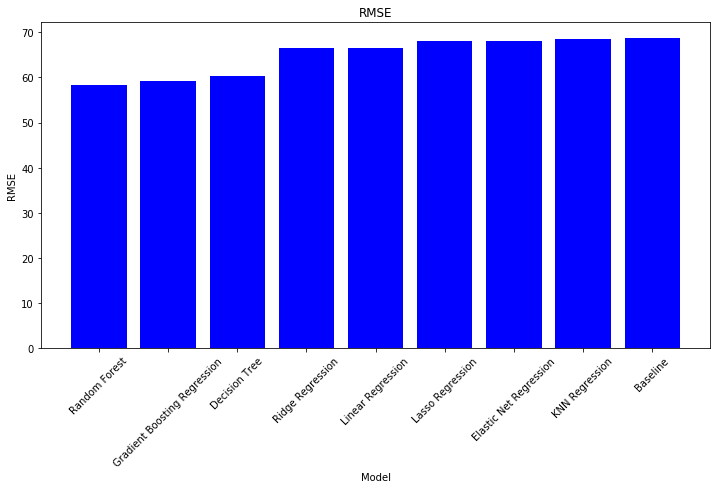

In [21]:
model_comparison(model_performance_dict, sort_by = 'R-squared', metric = 'RMSE')

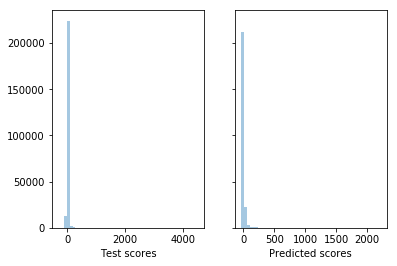

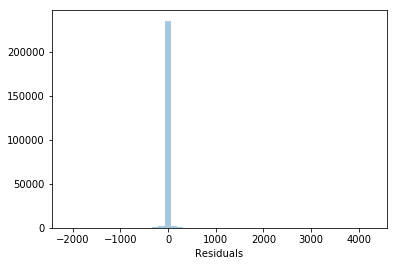

In [22]:
y_predicted = rf.predict(X_test)
plot_residuals(y_test,y_predicted)

In [23]:
rf_importances = get_feature_importance(rf)

link_score                    : 13.37%
no_of_past_comments           : 12.41%
time_since_link               :  9.93%
time_since_parent             :  9.75%
parent_score                  :  9.09%
gilded                        :  8.63%
title_euc                     :  4.25%
word_counts                   :  3.63%
title_cosine                  :  3.49%
comment_tree_root_score       :  2.69%
senti_neu                     :  2.52%
controversiality              :  2.22%
senti_comp                    :  2.21%
upvote_ratio                  :  1.75%
senti_neg                     :  1.71%
time_since_comment_tree_root  :  1.70%
depth                         :  1.65%
senti_pos                     :  1.51%
parent_cosine                 :  0.88%
parent_euc                    :  0.85%
subreddit_food                :  0.69%
is_edited                     :  0.66%
hour_of_comment               :  0.49%
subjectivity                  :  0.42%
no_of_linked_urls             :  0.31%
is_flair_css             